# Clustering Cars

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Reading and basic analysis of the dataset

In [2]:
#Reading the file
df = pd.read_csv('cars-dataset.csv')

In [3]:
#Looking at the top 5 rows
df.head()

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0
4,ford torino,8,302.0,140,3449,10.5,70,17.0


In [4]:
#Getting the shape of the dataset
print('No. of rows = ', df.shape[0])
print('No. of columns = ', df.shape[1])

No. of rows =  398
No. of columns =  8


In [5]:
#Looking at summary statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


**Insights**:  
1. Cylinder is right skewed (mean > median)
2. Displacement is right skewed
3. Weight, acc, year and mpg are more or less normally distributed
4. Horsepower did not show up in the describe output, it is supposed to be a continous numeric variable, need to check

### EDA1 - Looking for missing values

In [6]:
#Looking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


There see to be no null values in any of the column. We just have to take a closer look at the horesepower columnn to understand why it did not show up in the descibe output.

**Fixing the horsepower column**

In [7]:
#Looking at the datatype
df['hp'].dtypes

dtype('O')

Since it is an object type, this indicates that there are non numeric values present in this column.

In [8]:
# Creating a column to check whether the particular value in the hp column is a digit or not
df["horsepower_check"]= df['hp'].str.isdigit()

In [9]:
#Looking at those rows where horsepower_check is false (these rows are non numeric)
df[df['horsepower_check'] == False]['hp']

32     ?
126    ?
330    ?
336    ?
354    ?
374    ?
Name: hp, dtype: object

There are 6 rows in the hp column where there is a '?' symbol. We will have to replace this with the standard null value and impute the nulls with the median of the column.

In [10]:
#Dropping the horsepower_check column as it is not needed anymore
df.drop(columns='horsepower_check', inplace = True)

#Using the built in replace funtion to replace the '?' with np.nan
df['hp'] = df['hp'].replace({'?':np.nan})

#Converting the horsepower column to a float datatype
df['hp'] = df['hp'].astype('float')

#Using the fillna function to replace the null with the median
df['hp'].fillna(value = df['hp'].median(), inplace = True)

In [11]:
#Checking if the horsepower column appears in the describe output now
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
hp,398.0,104.304020,38.222625,46.0,76.000,93.5,125.000,230.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


Since the horsepower column now appears in the describe output we have successufully replaced the non numeric values present in it.

### EDA 2 - Outlier detection and treatment

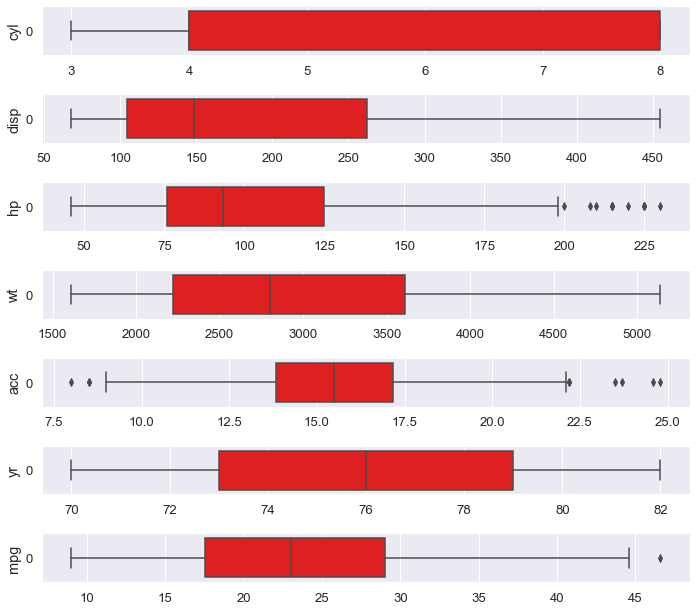

In [12]:
#Creating a loop to plot a boxplot for each column separately
i = 1
sns.set(font_scale=1.2)
for col in list(df.drop(columns = 'car name').columns):    
    plt.subplot(7,1,i)    
    plt.ylabel(col)
    plt.subplots_adjust(top=2, bottom=0, left=0, right = 1.5, hspace=0.8,
                    wspace=1.5)
    sns.boxplot(data = df[col], orient='h', color = 'red')
    i += 1

**Insights**:
1. Only two columns, hp and acc would require outlier treatment. 
2. mpg column has only one outlier, which is not too far from the whisker, so not treatment is necessary.

**Capping and Flooring the outliers in the hp and acc columns**

In [13]:
#Getting the IQR for the hp column
hp_q1 = df['hp'].quantile(q=0.25)
hp_q3 = df['hp'].quantile(q=0.75)
hp_iqr = hp_q3 - hp_q1

#Getting the IQR for the acc column
acc_q1 = df['acc'].quantile(q=0.25)
acc_q3 = df['acc'].quantile(q=0.75)
acc_iqr = acc_q3 - acc_q1

#Capping outliers in hp
df['hp'] = np.where(df['hp']>hp_q3+1.5*hp_iqr,hp_q3+1.5*hp_iqr, df['hp'] )

#Capping and flooring outliers in acc
df['acc'] = np.where(df['acc'] >acc_q3 + 1.5*acc_iqr,acc_q3 + 1.5*acc_iqr,\
                     np.where(df['acc'] <(acc_q1 - 1.5*acc_iqr),acc_q1 - 1.5*acc_iqr, df['acc'] ))

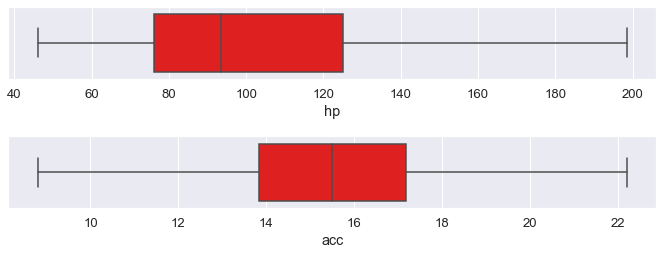

In [14]:
#Looking at the boxplots for the hp and acc columns again
plt.subplot(2,1,1)
sns.boxplot(df['hp'], color = 'red')
plt.subplot(2,1,2)
sns.boxplot(df['acc'], color = 'red')
plt.subplots_adjust(top=0.7, bottom=0, left=0, right = 1.5, hspace=0.8,
                    wspace=1.5)
plt.show()

We have successfully treated the major outliers in the dataset.

### EDA 3 - Correlation and relationship between variables

In [15]:
#Dropping the car_names variables as it does not contribute to clustering
df.drop(columns='car name', inplace = True)

**Pair Plot**

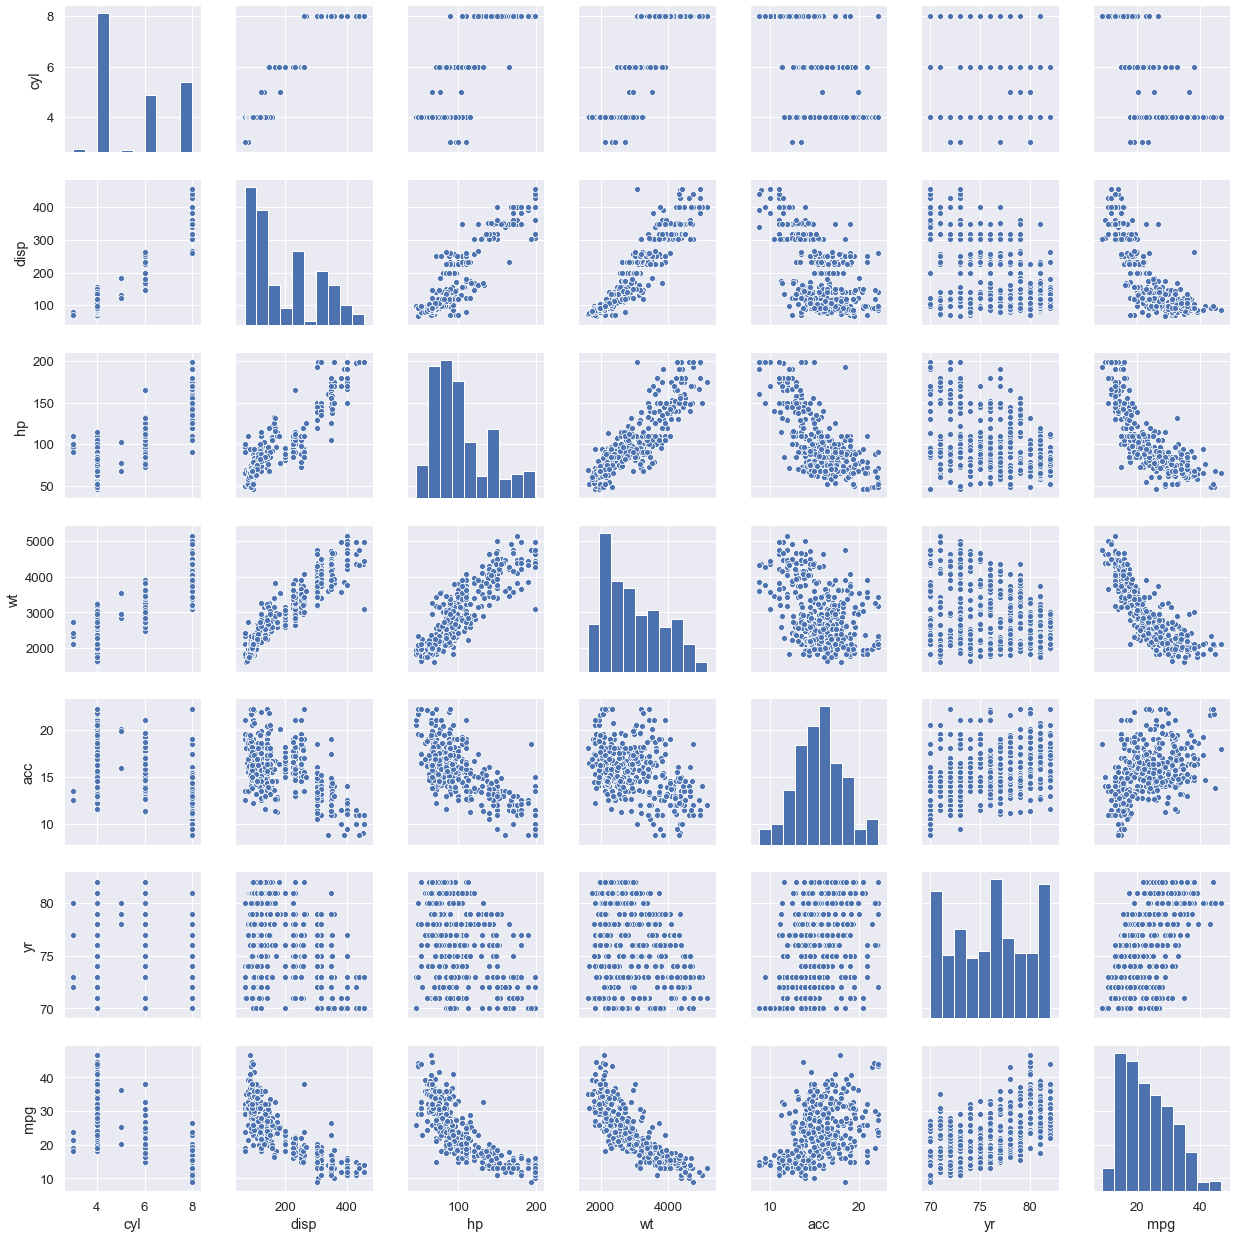

In [16]:
sns.pairplot(df, kind = 'scatter')
plt.show()

**Insights:**

**Looking at the bivariate plots**
* Heteroscedasticity is observed between mpg and disp, where there is a different behaviour in different intervals.
2. Disp, hp and weight are all inversely proportional to mpg.
3. mpg is also inversely proportional with cylinder.
4. Wt, disp and hp seem to have a positive correlation with each other, as one increases the other also increases.

**Looking at the histograms (variable plotted with itself)**:  
* Year has three modal points - 3 clusters
* Cylinder has three modal points - 3 clusters
* Hp has around 2 modal points - can have 2 clusters
* Mpg, disp and weight are right skewed and are unimodal - no visible clusters
* Acc is somewhat normally distributed and unimodal - no visible clusters

**Correlation Matrix**

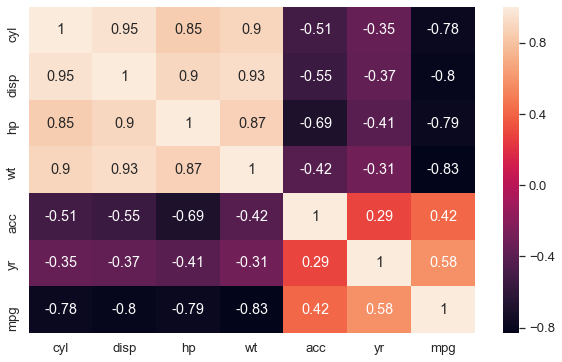

In [17]:
#Using heatmap
plt.figure(figsize=(10,6))
sns.set(font_scale = 1.2)
sns.heatmap(data = df.corr(),annot = True)
plt.show()

* Cyl, disp, hp and weight seem to have a high correlation (> 0.85)

### K-means clustering

In [18]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [19]:
#For loop to calculate inertia and sihouette score for different number of clusters
cluster_range = range( 2, 10)   #There might be around 2 to 6 clusters
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5, random_state=1)
  clusters.fit(df)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append(clusters.inertia_)    # capture the intertia
  cluster_sil_scores.append(metrics.silhouette_score(df, labels, metric='euclidean'))

# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame({"num_clusters":cluster_range, "cluster_errors": cluster_errors , "Avg_Sil_Score": cluster_sil_scores } )
clusters_df[0:15]

,num_clusters,cluster_errors,Avg_Sil_Score
0,2,7.425664e+07,0.634862
1,3,3.418347e+07,0.586141
2,4,1.903530e+07,0.579388
3,5,1.375176e+07,0.555633
4,6,1.029929e+07,0.525557
5,7,7.754435e+06,0.504229
6,8,5.648238e+06,0.523377
7,9,4.763064e+06,0.511640


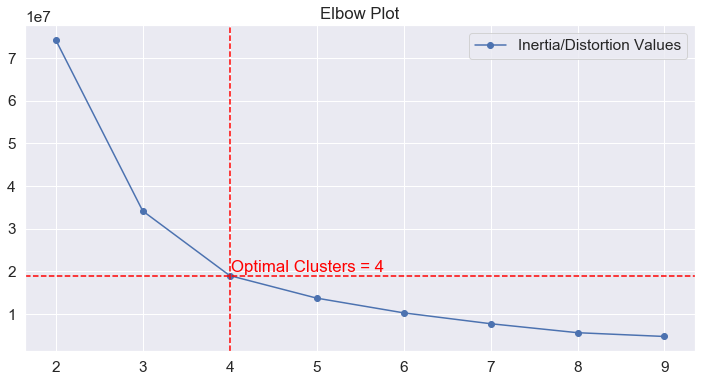

In [20]:
#Plotting the elbow plot
plt.figure(figsize=(12,6))
sns.set(font_scale=1.4)
plt.title('Elbow Plot')
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.axvline(x = 4, ls = '--',color = 'red')
plt.axhline(y = 1.9e+7, ls = '--',color = 'red')
plt.text(x = 4.01, y = 1.99e+7, s = 'Optimal Clusters = 4', color = 'red')
plt.legend(['Inertia/Distortion Values'])

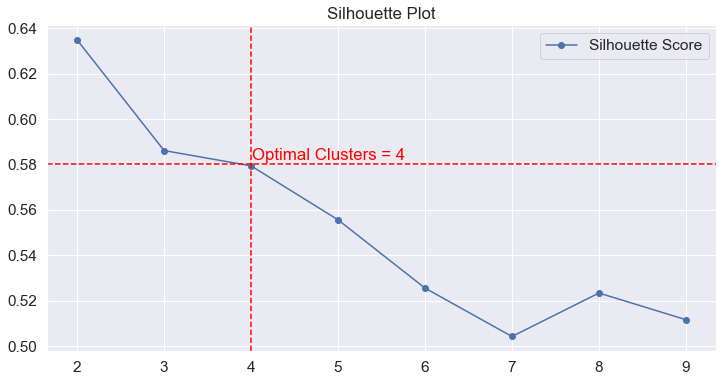

In [21]:
#Plotting the Silhouette Plot
plt.figure(figsize=(12,6))
sns.set(font_scale=1.4)
plt.title('Silhouette Plot')
plt.plot( clusters_df.num_clusters, clusters_df['Avg_Sil_Score'], marker = "o" )
plt.axvline(x = 4, ls = '--',color = 'red')
plt.axhline(y = 0.58, ls = '--',color = 'red')
plt.text(x = 4.01, y = 0.582, s = 'Optimal Clusters = 4', color = 'red')
plt.legend(['Silhouette Score'])

**Insight:** 
* Based on the elbow plot, number of clusters could be 3 or 4.
* But, where number of clusters is 4, we have an significant decrease in inertia and a relatively high sil score.
* Thus we shall use k = 4

### Using k = 4, Creating Clusters

In [22]:
#Fitting and Predicting the Clusters with k = 4
cluster = KMeans(n_clusters = 4, random_state=1)
cluster.fit(df)
df['Cluster'] = cluster.predict(df)

In [23]:
df['Cluster'] = df['Cluster'] + 1

### Understanding the Clusters

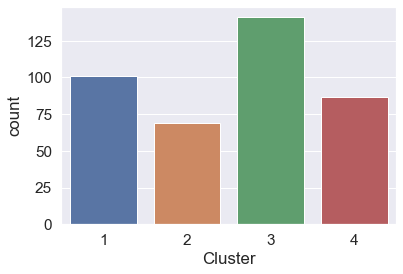

In [24]:
#Looking at the cluster distribution
sns.countplot(df['Cluster'])

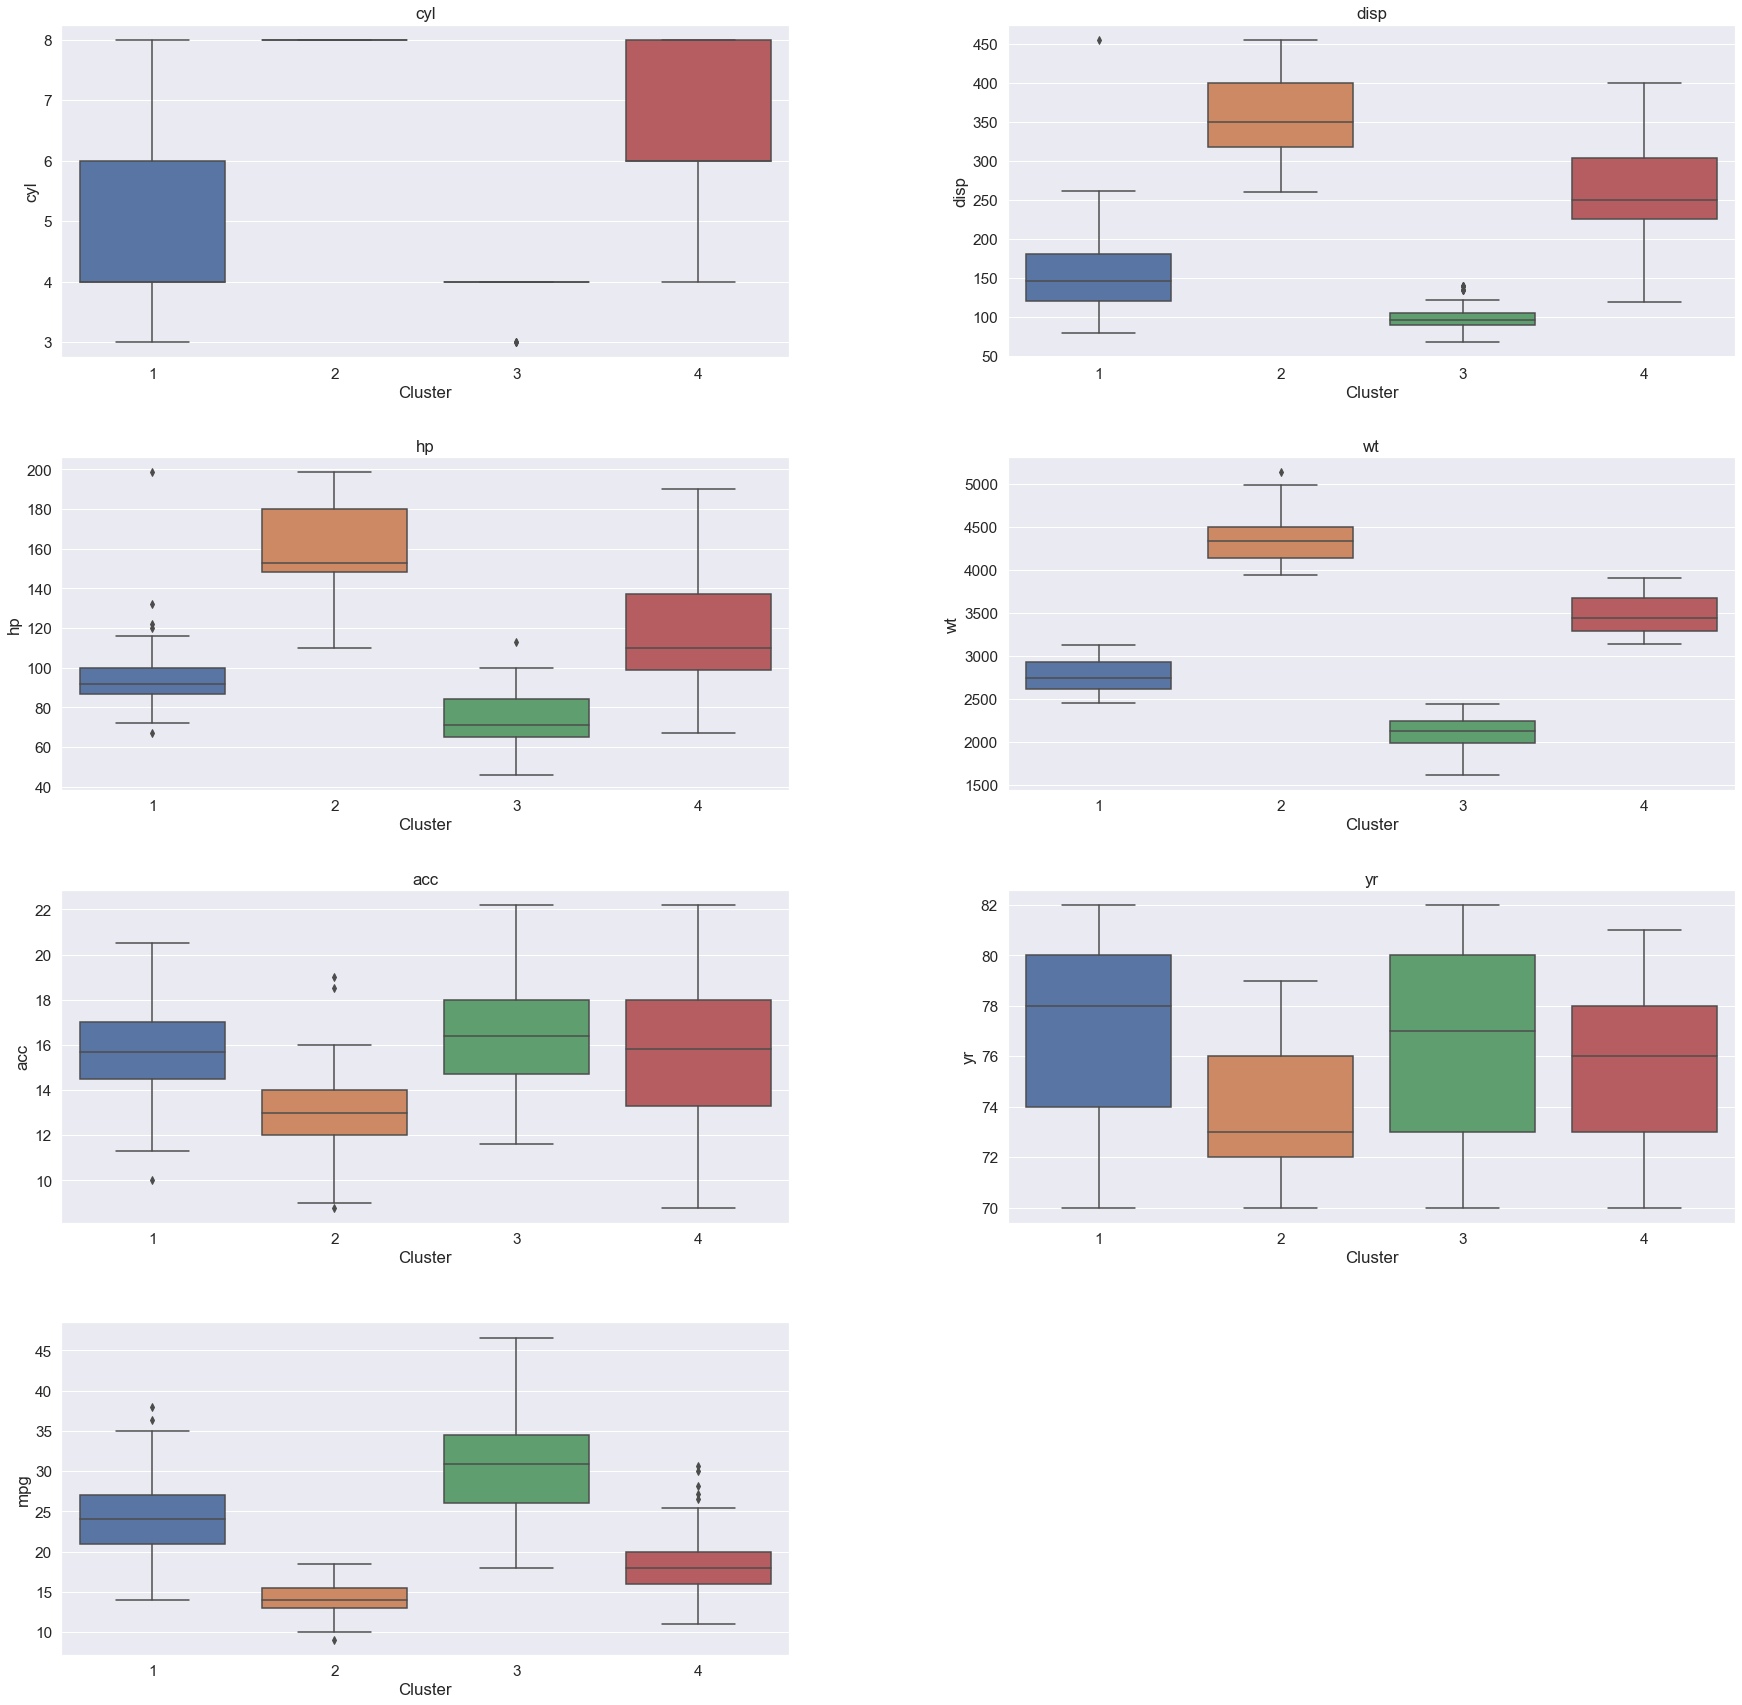

In [25]:
#Looking at boxplots of the clusters for each feature
cols = list(df.drop(columns = 'Cluster').columns)
plt.figure(figsize = (30,30))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
sns.set(font_scale = 1.4)
for i in range(0, len(cols)): 
    plt.title(cols[i-1])
    plt.subplot(4,2,i+1)
    sns.boxplot(x = 'Cluster', y = cols[i] , data = df)

### My Cluster Definitions:
* Cluster 1 - **Sports cars**, average attributes, **average mileage**.
2. Cluster 2 - **High end cars**, highest number of cylinders (all cars have 8 cylinders), high hp, high disp, high weight, **bad mileage**.
3. Cluster 3 - **Commercial cars**, less number of cylinders, low hp ,low disp, low weight, **good mileage**.
4. Cluster 4 - **SUVs, XUVs, FWDs**,  high number of cylinders, and average hp, disp and weight, **below average mileage**

***

### Running linear models on each cluster 

In [26]:
#Initializing the linear model object
from sklearn.linear_model import LinearRegression
Lr = LinearRegression()

In [27]:
#Creating a loop to fit model for each cluster separately and store the coefficients and intercept in a list
clusters = [1,2,3,4]
intercept = []
coeff = []
score = []
for cluster in clusters:
    X = df[df['Cluster'] == cluster].drop(columns = ['mpg','Cluster'])
    y = df[df['Cluster'] == cluster]['mpg']
    Lr.fit(X,y)
    coeff.append(Lr.coef_) 
    intercept.append(Lr.intercept_)
    score.append(Lr.score(X,y))

In [28]:
#Printing out the coefficients of the features for each cluster separately
#Getting the column names for the coeff_df
cols = []
for i in list(df.drop(columns = ['Cluster','mpg']).columns):
    cols.append(i+'_coeff')

#Creating the dataframe of coefficients
coeff_df = pd.DataFrame(data = coeff, columns= cols,
            index = ['Cluster1','Cluster2','Cluster3','Cluster4'])
#Getting the intercept
coeff_df['intercept'] = intercept
#Getting the accuracy scores
coeff_df['accuracy_score'] = score
print('DataFrame containing coefficients and intercept for each cluster:')
coeff_df

DataFrame containing coefficients and intercept for each cluster:


,cyl_coeff,disp_coeff,hp_coeff,wt_coeff,acc_coeff,yr_coeff,intercept,accuracy_score
Cluster1,-0.119694,0.001482,-0.061934,-0.006999,-0.181364,0.723689,-3.072394,0.578539
Cluster2,0.000000,-0.000904,-0.019468,-0.001604,-0.377054,0.420319,-1.538779,0.652085
Cluster3,10.034561,-0.078687,-0.005520,-0.005393,0.065950,1.017667,-68.671198,0.685044
Cluster4,-0.037384,-0.000977,-0.041626,-0.002293,-0.053251,0.529100,-7.472961,0.514992


***

### Conclusion

* We have identified that there were around **4 segments** of cars in our data, using **elbow plot and silhouette scores.**
* Once the clusters were made, **looking at the boxplots**, we were able to describe what these clusters were.
* The 4 segments of cars were, **Sports cars, High end cars, commercial cars and SUVs.**
* We then ran 4 different linear models for each of the clusters and **printed their coefficients separately**
* The accuracy of the linear models can be further improved with feature engineering and ensemble techniques.